# Combined Cycle Power Plant 

https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

Features consist of hourly average ambient variables 
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

% matplotlib inline


In [2]:
# Read in dataframe
df = pd.read_excel('CCPP/Folds5x2_pp.xlsx')
df.columns = ['temp', 'vacuum', 'pressure', 'humidity', 'net_energy']


In [3]:
df.head()

,temp,vacuum,pressure,humidity,net_energy
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [4]:
df.tail()

,temp,vacuum,pressure,humidity,net_energy
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74
9567,21.60,62.52,1017.23,67.87,453.28


In [5]:
df.describe()

,temp,vacuum,pressure,humidity,net_energy
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


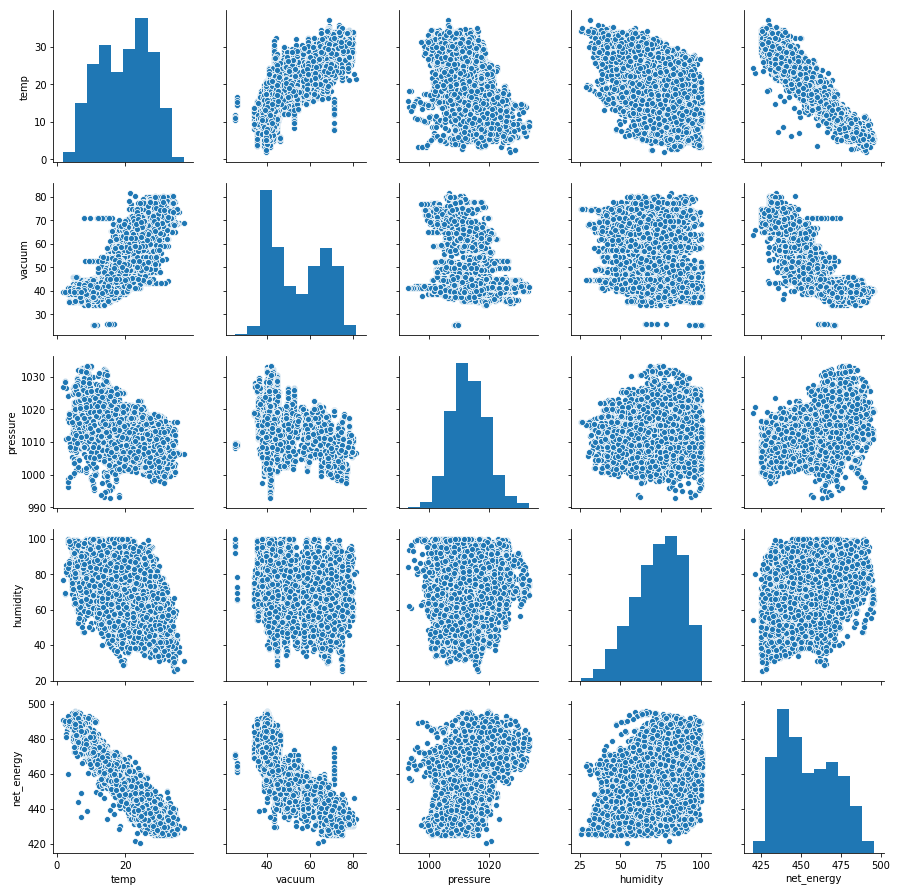

In [6]:
# Look at relationships between variables
# Tried taking sqrt of vacuum to improve linearity, but it did not improve
# the model, so it is not used
sns.pairplot(df)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Coefficients: 
 [-14.91568345  -2.90442067   0.29674292  -2.34657763]
Intercept: 
 454.3674550423846


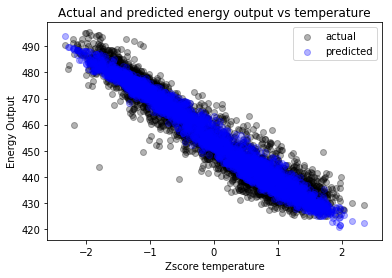

Linear Model Score: 0.93
Linear Model Cross Validation Accuracy: 0.93 (+/- 0.01)


In [7]:
# Use zscore to scale all parameters, I'll be doing this for KNN too
X = pd.DataFrame({
    'temp': stats.zscore(df.temp),
    'vacuum': stats.zscore(df.vacuum),
    'pressure': stats.zscore(df.pressure),
    'humidity': stats.zscore(df.humidity)
})

y = df['net_energy']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


# Create linear model
lm = LinearRegression()
lm.fit(X_train, y_train)

print('Coefficients: \n', lm.coef_)
print('Intercept: \n', lm.intercept_)

plt.scatter(X_test.temp, y_test, color = 'black', alpha=.3, label='actual')
plt.scatter(X_test.temp, lm.predict(X_test), color='blue', alpha=.3, label='predicted')
plt.title('Actual and predicted energy output vs temperature')
plt.xlabel('Zscore temperature')
plt.ylabel('Energy Output')
plt.legend()
plt.show()

print('Linear Model Score: {:.2f}'.format(lm.score(X_test, y_test)))

score_linear_cross = cross_val_score(lm, X_test, y_test, cv=5)

print("Linear Model Cross Validation Accuracy: %0.2f (+/- %0.2f)" % 
      (score_linear_cross.mean(), score_linear_cross.std() * 2))

ValueError: x and y must be the same size

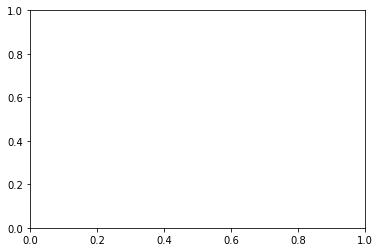

In [8]:
plt.scatter(y, lm.predict(X_test), color='blue', alpha=.3)
plt.title('Actual and predicted energy output')
plt.xlabel('Energy Output - Actual')
plt.ylabel('Energy Output - Predicted')
plt.show()

In [ ]:
# Look at some residuals
predicted = lm.predict(X_test).ravel()
actual = y_test

residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



In [ ]:
# Plot the predicted vs residual to check for homoscedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Not bad - looks fairly even.

## Now with KNN

In [ ]:
# Build the model
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

plt.scatter(y_test, y_pred_knn)
plt.xlabel('Actual Energy Output')
plt.ylabel('Predicted Energy Output')
plt.title('Actual vs. Predicted Energy Output for Test Data')
plt.show()

In [ ]:
min(X_train.vacuum)

In [ ]:
# Try a weighted knn
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X, y)

In [ ]:
score = cross_val_score(knn, X_test, y_test, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() *2))

score_w = cross_val_score(knn_w, X_test, y_test, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

In [ ]:
T = np.arange(-2.5, 2.5, .1)[:, np.newaxis]
knn_w2 = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w2.fit(X_test.temp.values.reshape(-1, 1), y_test)
Y_pred2 = knn_w2.predict(T)
plt.scatter(X_test.temp, y_test, c = 'k', label='data')
plt.plot(T, Y_pred2, c='g', label='prediction')
plt.xlabel('Z-score Temperature')
plt.ylabel('Predicted Energy')
plt.title('K=10, Weighted')
plt.legend()
plt.show()

KNN could be a better fit if the model isn't truly linear.  It is non-parametric and makes fewer assumptions about the data.  The slopes change could result in the nearest neighbor prediction giving a better estimate for fluctuations. 

The linear model is easier to interpret and easier to fit.   